In [93]:
import os, sys
import shutil
import numpy as np
import mne
import torch
from torcheeg import transforms
from torcheeg.datasets import DEAPDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm

sys.path.append(os.pardir)
from Utils import image_generation
from Utils_Bashivan import azim_proj

## Generate DEAP data

In [94]:
# paths
data_dir = os.path.join("..", "data", "deap")
raw_path = os.path.join(data_dir, "raw")
tmp_path = os.path.join(data_dir, "tmp_out")
preprocessed_path = os.path.join(data_dir, "preprocessed")
feature_path = os.path.join(data_dir, "features")

if not os.path.exists(feature_path):
    os.makedirs(feature_path)

if not os.path.exists(preprocessed_path):
    os.makedirs(preprocessed_path)

In [95]:
if os.path.exists(tmp_path):
    shutil.rmtree(tmp_path)

dataset = DEAPDataset(
    io_path=tmp_path,
    root_path=raw_path,
    online_transform=transforms.ToTensor(),
    label_transform=transforms.Select(['arousal', 'subject_id']),
    chunk_size=60*128,
    num_worker=8
)

[DEAP]:   0%|          | 0/32 [00:00<?, ?it/s]

The current io_size is not enough, and double the LMDB map size to 20971520 automatically.
The current io_size is not enough, and double the LMDB map size to 41943040 automatically.
The current io_size is not enough, and double the LMDB map size to 83886080 automatically.
The current io_size is not enough, and double the LMDB map size to 167772160 automatically.


[DEAP]:   3%|▎         | 1/32 [00:01<00:53,  1.73s/it]

The current io_size is not enough, and double the LMDB map size to 335544320 automatically.
The current io_size is not enough, and double the LMDB map size to 671088640 automatically.


[DEAP]:  56%|█████▋    | 18/32 [00:03<00:02,  6.01it/s]

The current io_size is not enough, and double the LMDB map size to 1342177280 automatically.


[DEAP]:  78%|███████▊  | 25/32 [00:05<00:01,  5.91it/s]

The current io_size is not enough, and double the LMDB map size to 2684354560 automatically.


[DEAP]: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]

Please wait for the writing process to complete...


In [96]:
print(f"num_samples: {len(dataset)}")
print(f"sample shape: {next(iter(dataset))[0].shape}")
print(f"label: {next(iter(dataset))[1]}")

num_samples: 1280
sample shape: torch.Size([32, 7680])
label: [5.65, 's16.dat']


### Write deap to .npy-file

In [97]:
samples = []
labels = []
participants = []

for i, (sample, label) in enumerate(dataset):
    samples.append(sample.unsqueeze(0))
    participants.append(int(label[1].split(".")[0].replace("s", "")))
    
    rating = label[0]
    if rating >= 5.0:
        rating = 1
    else:
        rating = 0
    
    labels.append(rating)

print(f"len samples: {len(samples)}")
print(f"len labels: {len(labels)}")
print(f"len participants: {len(participants)}")

# write to numpy
np.save(os.path.join(preprocessed_path, "X_data.npy"), np.vstack(samples))
np.save(os.path.join(feature_path, "labels.npy"), np.vstack(labels).squeeze(1))
np.save(os.path.join(feature_path, "participants.npy"), np.vstack(participants).squeeze(1))

label: [5.65, 's16.dat']
label: 5.65
label: 1
label: [6.45, 's19.dat']
label: 6.45
label: 1
label: [5.03, 's16.dat']
label: 5.03
label: 1
label: [6.09, 's24.dat']
label: 6.09
label: 1
label: [5.04, 's30.dat']
label: 5.04
label: 1
label: [6.81, 's19.dat']
label: 6.81
label: 1
label: [5.83, 's16.dat']
label: 5.83
label: 1
label: [6.09, 's24.dat']
label: 6.09
label: 1
label: [6.12, 's30.dat']
label: 6.12
label: 1
label: [4.78, 's20.dat']
label: 4.78
label: 0
label: [4.04, 's09.dat']
label: 4.04
label: 0
label: [5.97, 's31.dat']
label: 5.97
label: 1
label: [7.12, 's24.dat']
label: 7.12
label: 1
label: [7.78, 's14.dat']
label: 7.78
label: 1
label: [5.67, 's16.dat']
label: 5.67
label: 1
label: [7.04, 's19.dat']
label: 7.04
label: 1
label: [6.14, 's09.dat']
label: 6.14
label: 1
label: [5.92, 's30.dat']
label: 5.92
label: 1
label: [5.04, 's20.dat']
label: 5.04
label: 1
label: [7.9, 's16.dat']
label: 7.9
label: 1
label: [7.06, 's31.dat']
label: 7.06
label: 1
label: [7.9, 's14.dat']
label: 7.9
l

## Generate Features for DEAP

In [98]:
# get data
X_data = np.load(os.path.join(preprocessed_path, "X_data.npy"))
y_data = np.load(os.path.join(feature_path, "labels.npy"))

print(f"X_data: {X_data.shape}")
print(f"y_data: {y_data.shape}")

X_data: (1280, 32, 7680)
y_data: (1280,)


In [99]:
sampling_freq = 128
n_overlap = 0
n_per_seg = None # default 4 * sampling_freq
n_fft = 1024 # default 256

band_dict = {
    "delta": [1, 2],
    "theta": [3, 7],
    "alpha": [8, 13],
    "beta": [14, 29],
    "gamma": [30, 47]
}

deap_bands = [1, 3, 8, 14, 30, 48]

In [100]:
n_samples = X_data.shape[0] # number of participants (32) * trials (40)
n_channels = X_data.shape[1] # 32
n_features = n_channels * (len(deap_bands)- 1) # 32 * 5 = 160

print(f"n_samples: {n_samples}")
print(f"n_channels: {n_channels}")
print(f"n_features: {n_features}")

n_samples: 1280
n_channels: 32
n_features: 160


In [101]:
def frequency_binning_reduction(psd, freqs, bands, reduction='mean'):
    reduced_frequencies = np.empty(len(bands) - 1)
    
    for i in range(len(bands) - 1):
        low_freq = bands[i]
        high_freq = bands[i+1]
        freq_points_counter = 0
        freq_band_sum = 0
        for j, freq in enumerate(freqs):
            if freq >= low_freq and freq < high_freq:
                freq_points_counter += 1
                freq_band_sum += psd[j]
                
        reduced_frequencies[i] = freq_band_sum / freq_points_counter
        
    
    return reduced_frequencies

In [115]:
features = np.empty((n_samples, n_channels, len(deap_bands)- 1))
feature_matrix = np.empty((n_samples, n_features))

for i, subject_data in enumerate(X_data):
    reduced_psds = []
    psds, freqs = mne.time_frequency.psd_array_welch(subject_data, sfreq=sampling_freq, fmin=-1., fmax=60., n_fft=n_fft,
                                                     n_overlap=n_overlap, n_per_seg=n_per_seg, average='mean', verbose=50) 
    for j, psd_channel in enumerate(psds):        
        reduced_psd = frequency_binning_reduction(psd_channel, freqs, deap_bands)
        reduced_psds.append(reduced_psd)

    features[i] = np.stack(reduced_psds, axis=1).T
    feature_matrix[i] = np.stack(reduced_psds, axis=1).flatten()

print(f"features: {features.shape}")

features: (1280, 32, 5)


In [116]:
# save to file
np.save(os.path.join(feature_path, 'features.npy'), features)

### EEG Generate Images

In [104]:
eeg_image_size = 32

In [117]:
# get electrode locations
locs = np.load(os.path.join(os.pardir, 'Electroloc', 'Neuro_loc_DEAP.npy'))
locs_2d = np.empty((locs.shape[0], 2))

print(f"locs: {locs.shape}")
print(f"locs_2d: {locs_2d.shape}")

# project
for i, sensor_location in enumerate(locs):
    locs_2d[i] = azim_proj(sensor_location)

locs: (32, 3)
locs_2d: (32, 2)


In [118]:
eeg_images = image_generation(feature_matrix, locs_2d, eeg_image_size)
print(f"eeg_images: {eeg_images.shape}")

Signals interpolations.
eeg_images: (1280, 5, 32, 32)


In [119]:
normalized_images = np.zeros_like(eeg_images)

for i, image in enumerate(eeg_images):
    for channel in range(image.shape[0]):
        normalized_images[i, channel] = (image[channel] - np.min(image[channel])) / (np.max(image[channel]) - np.min(image[channel]))

    #plt.imshow(image_normalized[1:5].transpose(1, 2, 0), cmap=cm.cool)

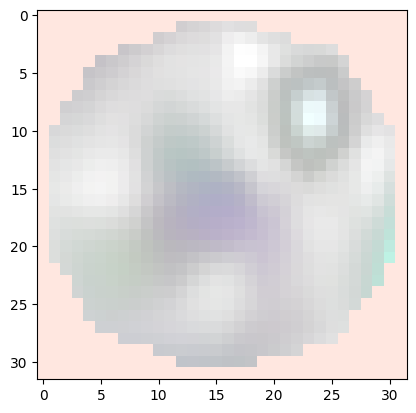

In [125]:
plt.imshow(normalized_images[30, 0:4].transpose(1, 2, 0), cmap=cm.cool)

In [ ]:
# save to file
np.save(os.path.join(feature_path, 'eeg_images.npy'), normalized_images)